In [1]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%load_ext autotime

time: 342 µs (started: 2021-08-16 12:47:12 +00:00)


### 0. Loading training data

In [2]:
df = pd.read_parquet('../data/processed/features.parquet')
df.shape

(73815, 341)

time: 316 ms (started: 2021-08-16 12:47:12 +00:00)


In [3]:
y, x = df.pop('country_destination'), df
x.drop('user_id', axis=1, inplace=True)

time: 291 ms (started: 2021-08-16 12:47:12 +00:00)


### 1. Splitting tain data into stratified train, validation and test sets

In [4]:
cat_features = [
    'gender',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'dow_registered',
    'hr_registered'
]

time: 905 µs (started: 2021-08-16 12:47:12 +00:00)


In [5]:
for col in cat_features:
    x[col].fillna('', inplace=True)
    x[col] = x[col].astype('category')

time: 277 ms (started: 2021-08-16 12:47:12 +00:00)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    train_size=0.9, 
    random_state=42,
    stratify=y
)
x_train.shape, x_test.shape

((66433, 339), (7382, 339))

time: 366 ms (started: 2021-08-16 12:47:13 +00:00)


In [7]:
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train, 
    y_train, 
    train_size=0.8,
    random_state=42,
    stratify=y_train
)
x_train.shape, x_validation.shape

((53146, 339), (13287, 339))

time: 448 ms (started: 2021-08-16 12:47:13 +00:00)


### 1.1 Checking that the ratios of the target class are invariant

In [8]:
# y_train.value_counts() / len(y_train)

time: 883 µs (started: 2021-08-16 12:28:12 +00:00)


In [9]:
# y_validation.value_counts() / len(y_validation)

time: 867 µs (started: 2021-08-16 12:28:12 +00:00)


### 2. Model Training

In [12]:
model = CatBoostClassifier(
    iterations=200,
    random_seed=42,
    learning_rate=0.05,
    custom_loss=['AUC', 'Accuracy'],
    loss_function='MultiClass',
#     eval_metric
)

time: 30.4 ms (started: 2021-08-16 12:29:57 +00:00)


In [13]:
model.fit(
    x_train, y_train,
    cat_features=cat_features,
    eval_set=(x_validation, y_validation),
    early_stopping_rounds=5,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

time: 12min 9s (started: 2021-08-16 12:29:58 +00:00)


### 3. Testing model on test sets

In [14]:
y_pred = model.predict(x_test)

time: 134 ms (started: 2021-08-16 12:42:25 +00:00)


In [16]:
labels = y_validation.value_counts().index.tolist()
labels

['NDF', 'US', 'other', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE', 'NL', 'AU', 'PT']

time: 10.1 ms (started: 2021-08-16 12:42:26 +00:00)


In [17]:
cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='all')

time: 34.4 ms (started: 2021-08-16 12:42:28 +00:00)


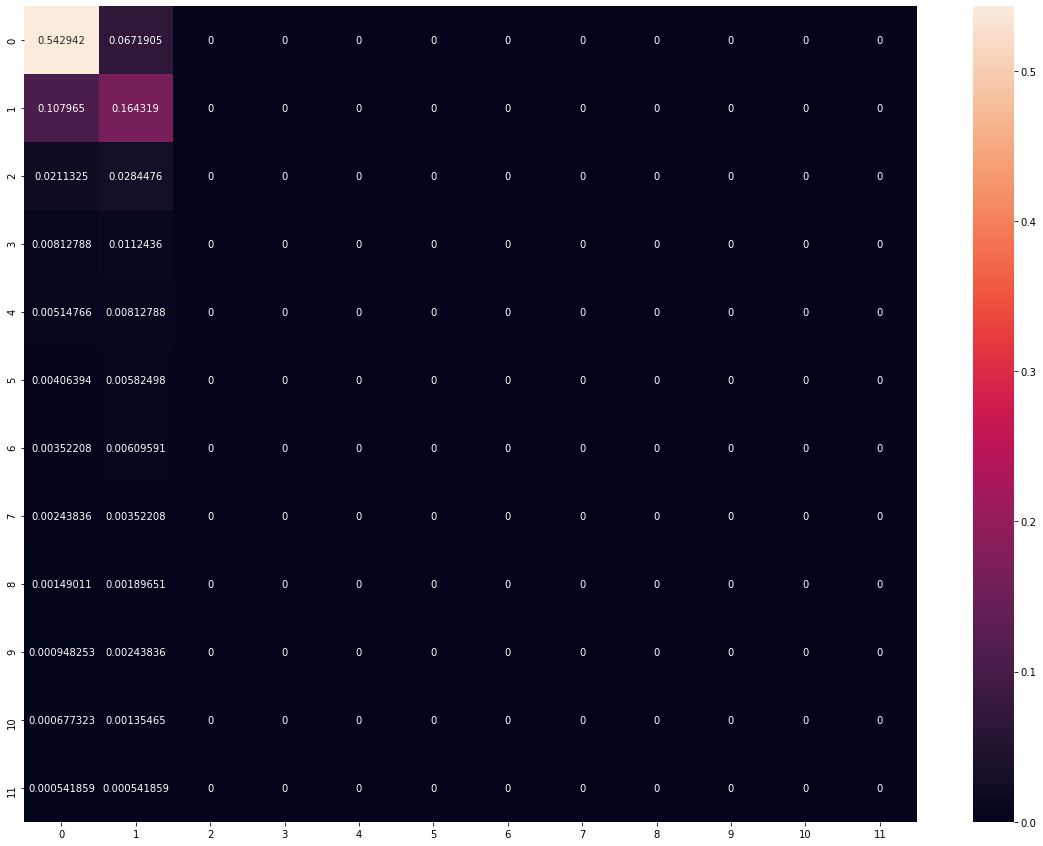

time: 896 ms (started: 2021-08-16 12:42:38 +00:00)


In [19]:
plt.figure(figsize = (20, 15))
sns.heatmap(cm, annot=True, fmt='g');

### 3.2 Model predictions with probabilities for each class

In [21]:
probs = model.predict_proba(x_test)

time: 84.9 ms (started: 2021-08-16 11:50:11 +00:00)


In [22]:
probs_df = pd.DataFrame(probs)
probs_df.shape

(7382, 12)

time: 8.98 ms (started: 2021-08-16 11:50:13 +00:00)


In [23]:
probs_df['amax'] = np.amax(probs, axis=1)

time: 4 ms (started: 2021-08-16 11:50:14 +00:00)


In [24]:
probs_df['true'] = y_test.reset_index(drop=True)
probs_df['pred'] = model.predict(x_test)

time: 42.5 ms (started: 2021-08-16 11:50:14 +00:00)


In [25]:
probs_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,amax,true,pred
0,0.001325,0.004019,0.001858,0.009762,0.014437,0.006579,0.007256,0.777023,0.002239,0.001261,0.146933,0.027308,0.777023,NDF,NDF
1,0.001407,0.014569,0.003581,0.010597,0.019501,0.012950,0.007875,0.136809,0.002175,0.000522,0.732202,0.057812,0.732202,NDF,US
2,0.001349,0.006396,0.002239,0.004712,0.012180,0.004250,0.007009,0.505511,0.001704,0.000756,0.373231,0.080663,0.505511,US,NDF
3,0.000421,0.000807,0.000264,0.001918,0.002211,0.001680,0.001753,0.929188,0.000151,0.000325,0.052037,0.009246,0.929188,NDF,NDF
4,0.002485,0.008276,0.002335,0.008434,0.017385,0.007074,0.012024,0.791059,0.001533,0.001404,0.118827,0.029163,0.791059,US,NDF


time: 26.6 ms (started: 2021-08-16 11:50:14 +00:00)


### 3.3 Analysis of probabilities where predictions are wrong

In [29]:
mask = probs_df['true'] != probs_df['pred']
mask.sum()

2180

time: 11.6 ms (started: 2021-08-16 11:51:09 +00:00)


In [30]:
probs_df[mask]['amax'].describe()

count    2180.000000
mean        0.590849
std         0.153684
min         0.182325
25%         0.468570
50%         0.557377
75%         0.704408
max         0.987340
Name: amax, dtype: float64

time: 16.8 ms (started: 2021-08-16 11:51:27 +00:00)


array([[<AxesSubplot:title={'center':'amax'}>]], dtype=object)

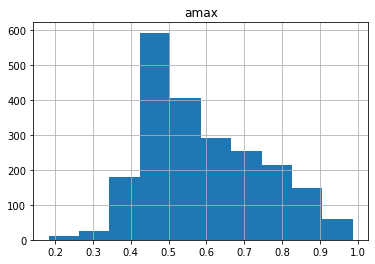

time: 383 ms (started: 2021-08-16 11:56:01 +00:00)


In [33]:
probs_df[mask].hist('amax')

In [40]:
(probs_df[mask]['amax'] < 0.5).sum() / mask.sum()

0.3555045871559633

time: 12 ms (started: 2021-08-16 12:11:35 +00:00)


In [41]:
(probs_df[~mask]['amax'] < 0.5).sum() / mask.sum()

0.2871559633027523

time: 19.1 ms (started: 2021-08-16 12:11:38 +00:00)


### 5. Saving Model

In [13]:
model.save_model('../models/model1.cbm')

time: 23.5 ms (started: 2021-08-16 09:59:15 +00:00)
